In [1]:
# !pip install shap
# !pip install lightfm
# !pip install catboost
# !pip install gdown

# 0. Configuration

In [2]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
# INTERACTIONS_PATH = '/content/drive/MyDrive/just for exps/interactions_df.csv'
INTERACTIONS_PATH = 'https://drive.google.com/file/d/1i6kmeJIUNJjqAa0vAvztFSDN3BFz9x1i/view?usp=share_link'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/12a80lS3vXQOl6i6ENgz-WqWw3Wms0nqB/view?usp=share_link'
USERS_DATA_PATH = 'https://drive.google.com/file/d/1MwPaye0cRi53czLqCnH0bOuvIhOeNlAx/view?usp=share_link'

# 1. Modules and functions

In [3]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import gdown
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. 1. Helper functions to avoid copy paste

In [4]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [5]:
# interactions data
output = 'interactions_df.csv'
interactions = pd.read_csv(gdown.download(url=INTERACTIONS_PATH, output=output, quiet=True, fuzzy=True))
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,656683,7107,2021-05-09,10,0.000
3,864613,7638,2021-07-05,14483,100.000
4,964868,9506,2021-04-30,6725,100.000


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [6]:
# information about films etc
movies_metadata = read_csv_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.000,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.000,"зарубежные, приключения, комедии",США,NaN,16.000,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.000,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.000,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [7]:
users_data = read_csv_from_gdrive(USERS_DATA_PATH)
users_data.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [8]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['total_dur'] > 300].reset_index(drop = True)

In [9]:
print(interactions.shape, interactions_filtered.shape)

(5476251, 5) (4195689, 5)


In [10]:
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

In [11]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 14

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2021-08-22 00:00:00
max date in filtered interactions:: 2021-03-13 00:00:00


In [12]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [13]:
TEST_MAX_DATE

Timestamp('2021-08-08 00:00:00')

In [14]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(3530674, 5) (665015, 5)


In [15]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2021-07-11 00:00:00


In [16]:
global_train = global_train.dropna().reset_index(drop = True)

In [17]:
local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(2451040, 5) (1079183, 5)


In [18]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(579382, 5)


In [19]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

In [20]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [21]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  539173
user features mapper length -  539173
movies mapper length -  13006
Users movie features mapper length -  13006


In [22]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [23]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [24]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [25]:
train_mat

<539173x13006 sparse matrix of type '<class 'numpy.int32'>'
	with 2451040 stored elements in COOrdinate format>

In [26]:
train_mat_weights

<539173x13006 sparse matrix of type '<class 'numpy.float32'>'
	with 2451040 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [27]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [28]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [29]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 713676, row number in matrix - 62


In [31]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

13006

In [32]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 1.7937789,  1.3589829, -2.608041 , ..., -2.8011758, -2.3293169,
        -2.3307717], dtype=float32),
 (13006,))

In [33]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([435,  87,   5, 168, 298,  61,  20,  67,  15,  78])

In [34]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['item_id'], movies_metadata['title']))

In [35]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,435,13018,Король лев (2019)
1,87,16166,Зверополис
2,5,7571,100% волк
3,168,3182,Ральф против Интернета
4,298,13915,Вперёд
5,61,4436,Ford против Ferrari
6,20,7626,Мстители: Война бесконечности
7,67,8636,Белый снег
8,15,1819,Непосредственно Каха
9,78,12501,Во всё тяжкое


In [36]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1000]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 869219, row number in matrix - 675


In [37]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([-4.2828824e-04, -8.5934711e-01, -2.5532088e+00, ...,
        -3.4012403e+00, -3.2486756e+00, -2.8219926e+00], dtype=float32),
 (13006,))

In [38]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([1651,  222, 1185,  493, 1596, 1259,  181,  401,  316,  682])

In [39]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,1651,11231,Заклятье. Дом 32
1,222,676,Человек-невидимка
2,1185,15362,[4К] Гнев человеческий
3,493,3620,Прочь
4,1596,12179,Мистер Бин
5,1259,2171,Большой босс
6,181,14317,Веном
7,401,4696,Удивительное путешествие доктора Дулиттла
8,316,3693,Проклятие Лауры.Завещание
9,682,16361,Doom: Аннигиляция


In [40]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

144739

In [41]:
# all_recs = pd.DataFrame()
# for user in tqdm_notebook(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [42]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [43]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [44]:
test_preds['item_id'] = test_preds['user_id'].map(mapper)

In [45]:
test_preds = test_preds.explode('item_id')
test_preds.shape

(1447390, 2)

In [46]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [47]:
test_preds.head()

,user_id,item_id,rank
0,646903,16361,1
0,646903,10440,2
0,646903,14359,3
0,646903,14317,4
0,646903,9728,5


In [48]:
test_preds['item_name'] = test_preds['item_id'].map(item_name_mapper)
test_preds.head()

,user_id,item_id,rank,item_name
0,646903,16361,1,Doom: Аннигиляция
0,646903,10440,2,Хрустальный
0,646903,14359,3,Проклятие ведьмы
0,646903,14317,4,Веном
0,646903,9728,5,Гнев человеческий


In [49]:
# sense check for diversity of recommendations
test_preds.item_id.nunique()

1730

## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [50]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(77330, 8)

In [51]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(274012, 8)

In [52]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [53]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [54]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [55]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:           user_id       rank   total_dur  watched_pct     target
count  280883.000 280883.000   61668.000    61668.000 280883.000
mean   548565.020      5.297   18491.124       65.472      0.220
std    316270.211      2.885   34932.193       36.823      0.414
min        11.000      1.000     301.000        0.000      0.000
25%    274670.500      3.000    3985.000       25.000      0.000
50%    548996.000      5.000    7784.500       81.000      0.000
75%    822223.000      8.000   22548.250      100.000      0.000
max   1097528.000     10.000 2414017.000      100.000      1.000 
, TEST:           user_id      rank   total_dur  watched_pct    target
count   70459.000 70459.000   15662.000    15662.000 70459.000
mean   548875.515     5.306   19042.879       65.283     0.222
std    317503.028     2.879   37827.136       36.843     0.416
min       106.000     1.000     302.000        0.000     0.000
25%    271427.000     3.000    3962.000       25.000     0.000
50%    551283.000    

In [56]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']

In [57]:
# joins user features
cbm_train_set = pd.merge(cbm_train_set,users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_data[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])

In [58]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])


In [59]:
print(cbm_train_set.shape, cbm_test_set.shape)

(280883, 16) (70459, 16)


In [60]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,198126,8350,9,Перевозчик,NaT,NaN,NaN,0,age_35_44,income_20_40,Ж,0.000,film,2002.000,NaN,16.000
1,803847,13865,5,Девятаев,NaT,NaN,NaN,0,age_25_34,income_40_60,М,0.000,film,2021.000,NaN,12.000
2,1094043,14741,4,Цвет из иных миров,NaT,NaN,NaN,0,age_45_54,income_40_60,М,1.000,film,2020.000,NaN,16.000
3,127837,1844,9,Аферистка,NaT,NaN,NaN,0,age_35_44,income_60_90,М,1.000,film,2020.000,NaN,18.000
4,573943,15297,2,Клиника счастья,2021-07-14,21647.000,63.000,1,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000


In [61]:
cbm_train_set.columns

Index(['user_id', 'item_id', 'rank', 'item_name', 'last_watch_dt', 'total_dur',
       'watched_pct', 'target', 'age', 'income', 'sex', 'kids_flg',
       'content_type', 'release_year', 'for_kids', 'age_rating'],
      dtype='object')

In [62]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [63]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(280883, 9) (70459, 9)


In [64]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,9,age_35_44,income_20_40,Ж,0.000,film,2002.000,NaN,16.000
1,5,age_25_34,income_40_60,М,0.000,film,2021.000,NaN,12.000
2,4,age_45_54,income_40_60,М,1.000,film,2020.000,NaN,16.000
3,9,age_35_44,income_60_90,М,1.000,film,2020.000,NaN,18.000
4,2,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000


In [65]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

## 2.5.2. Train Model

In [66]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [67]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS 
)

0:	learn: 0.6506518	test: 0.6510800	best: 0.6510800 (0)	total: 260ms	remaining: 21m 39s
1:	learn: 0.6167502	test: 0.6175934	best: 0.6175934 (1)	total: 469ms	remaining: 19m 32s
2:	learn: 0.5906170	test: 0.5918138	best: 0.5918138 (2)	total: 631ms	remaining: 17m 30s
3:	learn: 0.5700513	test: 0.5715696	best: 0.5715696 (3)	total: 779ms	remaining: 16m 13s
4:	learn: 0.5539998	test: 0.5558248	best: 0.5558248 (4)	total: 1.04s	remaining: 17m 20s
5:	learn: 0.5414848	test: 0.5436023	best: 0.5436023 (5)	total: 1.32s	remaining: 18m 16s
6:	learn: 0.5317563	test: 0.5340970	best: 0.5340970 (6)	total: 1.61s	remaining: 19m 11s
7:	learn: 0.5243218	test: 0.5269010	best: 0.5269010 (7)	total: 1.92s	remaining: 19m 59s
8:	learn: 0.5178648	test: 0.5206462	best: 0.5206462 (8)	total: 2.24s	remaining: 20m 40s
9:	learn: 0.5131242	test: 0.5160906	best: 0.5160906 (9)	total: 2.54s	remaining: 21m 9s
10:	learn: 0.5093862	test: 0.5125406	best: 0.5125406 (10)	total: 2.87s	remaining: 21m 40s
11:	learn: 0.5065353	test: 0.50

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [68]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

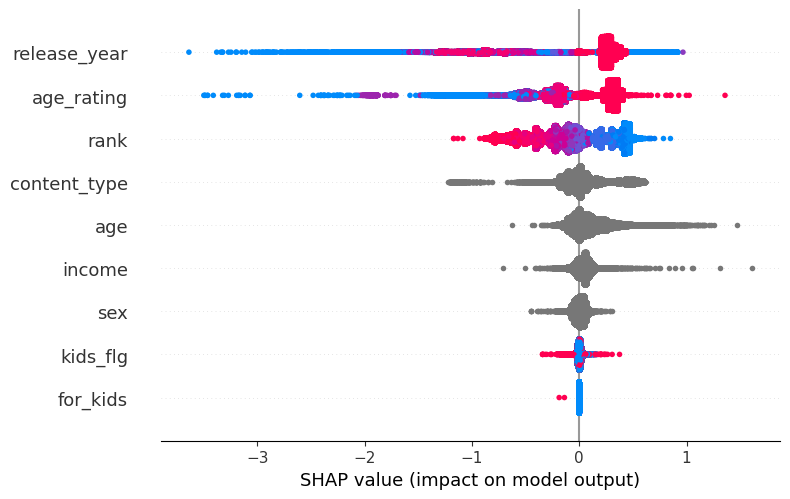

In [69]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [70]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [71]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.68


# TODO
- Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM separately, LightFM + Ranker

## Task 1.
* Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM separately.

In [72]:
# we will focus on warm start - remove cold start users
global_test = global_test[global_test['user_id'].isin(local_train['user_id'].unique())]

In [73]:
top_N = 100

# let's make predictions for all users in global test
global_test_preds = pd.DataFrame({
    'user_id': global_test['user_id'].unique()
    })

# form user-known items
known_items = {user_id: item_id_gr['item_id'].to_list() for user_id, item_id_gr in local_train[['user_id', 'item_id']].groupby('user_id')}

In [74]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

global_test_preds['item_id'] = global_test_preds['user_id'].map(mapper)
global_test_preds = global_test_preds.explode('item_id').reset_index(drop=True)
global_test_preds['rank'] = global_test_preds.groupby('user_id').cumcount() + 1 

In [75]:
def compute_metrics(df_true: pd.DataFrame, 
                    df_pred: pd.DataFrame, 
                    K: int, 
                    rank_col: str = 'rank') -> pd.DataFrame:

    result = pd.DataFrame(columns=['Metric', 'Value'])

    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()

    for k in range(1, K + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result.loc[len(result.index)] = [f'Precision@{k}', (test_recs[hit_k] / k).sum() / users_count]

    result.loc[len(result.index)] = [f'MAP@{K}', (test_recs['cumulative_rank'] / test_recs['users_item_count']).sum() / users_count]
    result.loc[len(result.index)] = [f'MRR', test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()]
    
    return result

In [76]:
lfm_metrics = compute_metrics(global_test[['user_id', 'item_id']],
                              global_test_preds, 
                              K=10)
lfm_metrics

,Metric,Value
0,Precision@1,0.052
1,Precision@2,0.049
2,Precision@3,0.044
3,Precision@4,0.040
4,Precision@5,0.038
5,Precision@6,0.035
6,Precision@7,0.033
7,Precision@8,0.031
8,Precision@9,0.029
9,Precision@10,0.028


## Task 2.
* Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM + Ranker.

In [77]:
global_test_lfm_ctb_preds = global_test_preds.copy()

# joins user features
global_test_lfm_ctb_set = pd.merge(global_test_lfm_ctb_preds, 
                                   users_data[['user_id'] + USER_FEATURES],
                                   how='left', on=['user_id'])
# joins item features
global_test_lfm_ctb_set = pd.merge(global_test_lfm_ctb_set, 
                                   movies_metadata[['item_id'] + ITEM_FEATURES],
                                   how='left', on=['item_id'])

global_test_lfm_ctb_set = global_test_lfm_ctb_set.fillna(global_test_lfm_ctb_set.mode().iloc[0])

In [78]:
global_test_lfm_ctb_set.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,203219,15297,1,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000
1,203219,10440,2,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000
2,203219,4151,3,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000
3,203219,4880,4,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000
4,203219,2657,5,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,16.000


In [79]:
ctb_prediction = cbm_classifier.predict_proba(global_test_lfm_ctb_set.drop(ID_COLS, axis=1, errors='ignore'))

global_test_lfm_ctb_preds['ctb_pred'] = ctb_prediction[:, 1]
global_test_lfm_ctb_preds.head()

,user_id,item_id,rank,ctb_pred
0,203219,15297,1,0.363
1,203219,10440,2,0.339
2,203219,4151,3,0.282
3,203219,4880,4,0.268
4,203219,2657,5,0.160


In [80]:
global_test_preds.sort_values(by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,rank
5673274,14,10436,75
5673272,14,10077,73
5673271,14,13935,72
5673270,14,16509,71
5673269,14,6626,70
5673268,14,5693,69
5673267,14,4685,68
5673266,14,12192,67
5673265,14,657,66
5673264,14,13915,65


In [81]:
global_test_lfm_ctb_preds = global_test_lfm_ctb_preds.sort_values(by=['user_id', 'ctb_pred'], 
                                                                  ascending=[True, False])
global_test_lfm_ctb_preds['rank_ctb'] = global_test_lfm_ctb_preds.groupby('user_id').cumcount() + 1
global_test_lfm_ctb_preds.head(10)

,user_id,item_id,rank,ctb_pred,rank_ctb
5673204,14,9728,5,0.377,1
5673200,14,10440,1,0.363,2
5673201,14,15297,2,0.339,3
5673202,14,13865,3,0.322,4
5673223,14,14703,24,0.287,5
5673205,14,3734,6,0.276,6
5673203,14,4151,4,0.268,7
5673280,14,14461,81,0.192,8
5673256,14,16228,57,0.191,9
5673276,14,1465,77,0.191,10


In [82]:
pd.crosstab(global_test_lfm_ctb_preds[global_test_lfm_ctb_preds['rank'] <= 10]['rank'], 
            global_test_lfm_ctb_preds[global_test_lfm_ctb_preds['rank_ctb'] <= 10]['rank_ctb'])\
    .style.background_gradient(cmap='spring')

rank_ctb,1,2,3,4,5,6,7,8,9,10
rank,,,,,,,,,,
1,37807,19541,4651,1789,921,634,708,684,461,354
2,11473,26817,15227,4391,1670,1291,1183,1449,1076,666
3,6926,7336,11575,12399,8731,5401,2671,2012,1346,953
4,5919,4588,7959,8334,6381,6604,5697,3836,1591,1225
5,6317,3081,6560,5987,5962,6601,6067,3118,1777,1425
6,2527,1847,3018,4621,6801,9737,7962,3947,1943,1624
7,1029,1779,1805,2290,3157,4868,6344,5854,3600,2430
8,412,906,1624,1672,1506,2247,4345,5506,4216,3511
9,380,734,1523,1573,1563,2189,3476,4762,4237,2858


In [83]:
lfm_cbm_metrics = compute_metrics(global_test[['user_id', 'item_id']],
                                  global_test_lfm_ctb_preds, 
                                  K=10, 
                                  rank_col='rank_ctb')
lfm_cbm_metrics

,Metric,Value
0,Precision@1,0.062
1,Precision@2,0.055
2,Precision@3,0.049
3,Precision@4,0.043
4,Precision@5,0.039
5,Precision@6,0.036
6,Precision@7,0.033
7,Precision@8,0.031
8,Precision@9,0.029
9,Precision@10,0.028


## * Task 3.
* Comparison of LightFM separately and LightFM + Ranker Precision@K evaluation.

In [84]:
comparison_df = lfm_metrics.merge(lfm_cbm_metrics, how='left', on='Metric')
comparison_df = comparison_df.rename(columns = {'Value_x': 'LightFM', 'Value_y': 'LightFM + Ranker'})
comparison_df

,Metric,LightFM,LightFM + Ranker
0,Precision@1,0.052,0.062
1,Precision@2,0.049,0.055
2,Precision@3,0.044,0.049
3,Precision@4,0.040,0.043
4,Precision@5,0.038,0.039
5,Precision@6,0.035,0.036
6,Precision@7,0.033,0.033
7,Precision@8,0.031,0.031
8,Precision@9,0.029,0.029
9,Precision@10,0.028,0.028


In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
style.use('seaborn-whitegrid')

%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

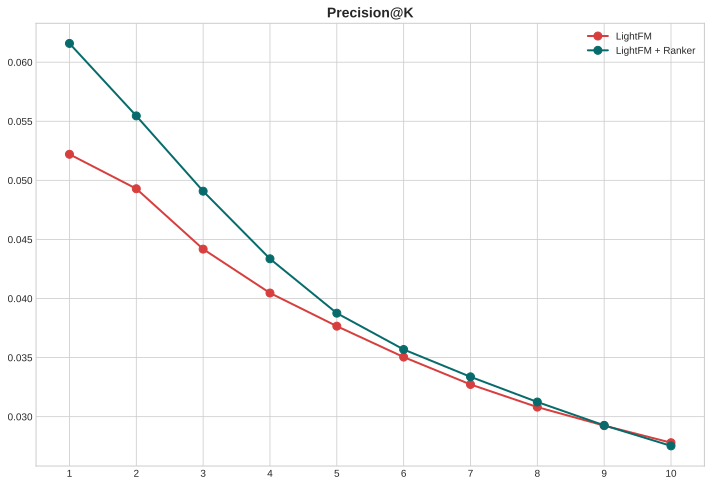

In [86]:
plt.plot(np.arange(1, 11), comparison_df['LightFM'].iloc[:10], 
         label='LightFM', linewidth=2, marker='o', markersize=8, color='#D73E3E')
plt.plot(np.arange(1, 11), comparison_df['LightFM + Ranker'].iloc[:10], 
         label='LightFM + Ranker', linewidth=2, marker='o', markersize=8, color='#076B6B')

plt.xlim(0.5, 10.5)
plt.xticks(np.arange(1, 11), fontsize=10)
plt.yticks(fontsize=10)

plt.title(label='Precision@K', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)

plt.show()